In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import numpy.ma as ma
from dateutil.rrule import rrule, MONTHLY
import collections
from tqdm import tqdm
from global_land_mask import globe
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.cm import get_cmap
from dateutil import relativedelta
from datetime import datetime

In [2]:
# DATA USED: Omega (dp/dt), Mean, Multiplee levels, Monthly
fn = 'C:/Users/Owner/Documents/Thesis/Code/Data_Extraction/McRobie_Data_Extraction/omega.mon.mean.nc'
ds = nc.Dataset(fn)

data = xr.open_dataset(fn)

In [3]:
data

<xarray.Dataset>
Dimensions:  (lat: 73, level: 12, lon: 144, time: 896)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 250.0 200.0 150.0 100.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-08-01
Data variables:
    omega    (time, level, lat, lon) float32 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:09:59 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean omega from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

# Extract Time Variable 

In [25]:
time = ds.variables['time']
time_array = ma.MaskedArray.tolist(time[:])

# Assume data exists for every month (i.e., data set is complete)

start_date = datetime(1948,1,1) #Start date of the dataset yyyy,mm,dd

# Format data to sample ONLY UNTIL 2013
all_dates = list(rrule(freq=MONTHLY, count=795,dtstart=start_date)) # 794 = February 2014,  795 = March 2014

final_times_all = [] #List of all dates in the data in string dd-mm-yyyy format
for i in all_dates:
    final_times_all.append(i.strftime('%d-%m-%Y'))

C:\Users\Owner\AppData\Local\Temp\ipykernel_2596\931652436.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time_array = ma.MaskedArray.tolist(time[:])


# Extract Latitude/Longitude Data

In [26]:
longitude = ds.variables['lon']
latitude = ds.variables['lat']

latitude_unmask = ma.MaskedArray.tolist(latitude[:]) #Create array of latitude values length 96
lon = [x-180 for x in ds.variables['lon'][:]] #Create array of transformed longitude values length 192

C:\Users\Owner\AppData\Local\Temp\ipykernel_2596\968244543.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitude_unmask = ma.MaskedArray.tolist(latitude[:]) #Create array of latitude values length 96
C:\Users\Owner\AppData\Local\Temp\ipykernel_2596\968244543.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = [x-180 for x in ds.variabl

In [27]:
# Make lists for values that return TRUE
land_list_lat = []
land_list_lon = []

# Make lists for values that return FALSE
ocean_list_lat = []
ocean_list_lon = []

for i in latitude_unmask:
    for j in lon:
        if globe.is_land(i,j)==True:
            land_list_lat.append(i)
            land_list_lon.append(j)
        else:
            ocean_list_lat.append(i)
            ocean_list_lon.append(j)
            
land_coords = list(zip(land_list_lat,land_list_lon)) # Create (latitude,longitude) pairs for all land coordinates
ocean_coords = list(zip(ocean_list_lat,ocean_list_lon)) # Create (latitude,longitude) pairs for all ocean coordinates
world_coords = land_coords + ocean_coords

In [28]:
#Create dictionary with each latitude value corresponding to index value
latitude_dict = dict(zip([x for x in range(len(latitude_unmask))],latitude_unmask)) #These are correct
longitude_dict = dict(zip([x for x in range(len(lon))],lon)) #These are also correct according to the sorting of the lists

land_lat_indices = []
land_lon_indices = []

ocean_lat_indices = []
ocean_lon_indices = []

for i in land_list_lat:
    land_lat_indices.append(list(latitude_dict.keys())[list(latitude_dict.values()).index(i)])
    
for i in land_list_lon:
    land_lon_indices.append(list(longitude_dict.keys())[list(longitude_dict.values()).index(i)])
    
for i in ocean_list_lat:
    ocean_lat_indices.append(list(latitude_dict.keys())[list(latitude_dict.values()).index(i)])
    
for i in ocean_list_lon:
    ocean_lon_indices.append(list(longitude_dict.keys())[list(longitude_dict.values()).index(i)])

world_list_lat = land_list_lat+ocean_list_lat
world_list_lon = land_list_lon+ocean_list_lon

land_indices = list(zip(land_lat_indices,land_lon_indices))
ocean_indices = list(zip(ocean_lat_indices,ocean_lon_indices))
world_indices = land_indices + ocean_indices

land_total = list(zip(land_lat_indices,land_lon_indices,land_list_lat,land_list_lon))
ocean_total = list(zip(ocean_lat_indices,ocean_lon_indices,ocean_list_lat,ocean_list_lon))

land = pd.DataFrame(land_total,columns=['Latitude Index','Longitude Index','Latitude','Longitude'])
land_index=land.index
land_index.name='Land Measurements'

ocean = pd.DataFrame(ocean_total,columns=['Latitude Index','Longitude Index','Latitude','Longitude'])
ocean_index=ocean.index
ocean_index.name='Ocean Measurements'

world = pd.concat([land,ocean])

print(land)
print(ocean)
print(world)

                   Latitude Index  Longitude Index  Latitude  Longitude
Land Measurements                                                      
0                               3               40      82.5      -80.0
1                               3               41      82.5      -77.5
2                               3               42      82.5      -75.0
3                               3               43      82.5      -72.5
4                               3               44      82.5      -70.0
...                           ...              ...       ...        ...
3517                           72              139     -90.0      167.5
3518                           72              140     -90.0      170.0
3519                           72              141     -90.0      172.5
3520                           72              142     -90.0      175.0
3521                           72              143     -90.0      177.5

[3522 rows x 4 columns]
                    Latitude Index  Lon

In [29]:
ocean_total_dict = dict(zip(zip(ocean_list_lat,ocean_list_lon),zip(ocean_lat_indices,ocean_lon_indices)))
land_total_dict = dict(zip(zip(land_list_lat,land_list_lon),zip(land_lat_indices,land_lon_indices)))
world_total_dict = {**ocean_total_dict,**land_total_dict}

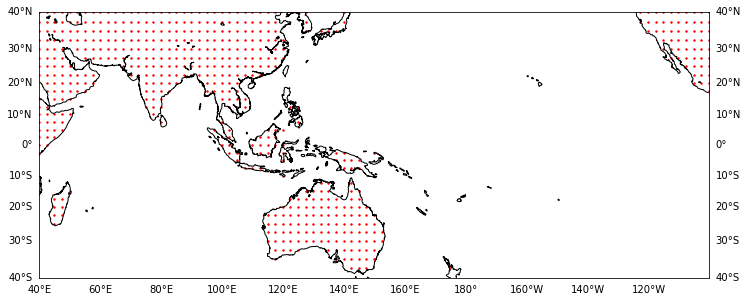

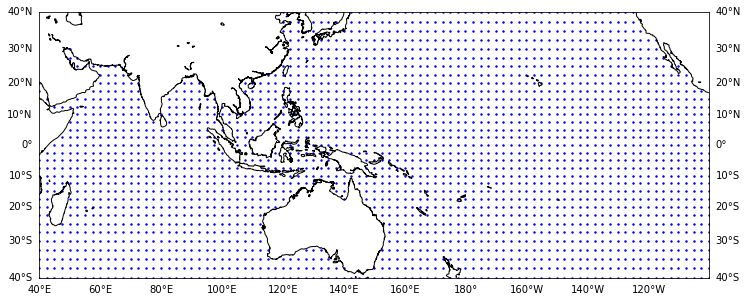

In [30]:
plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(land_list_lon,land_list_lat,latlon=True,s=2,c='red')

plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2], linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2], linewidth=0.0)
m.scatter(ocean_list_lon,ocean_list_lat,latlon=True,s=2,c='blue')

In [31]:
nw_lat_min,nw_lat_max = -20,-10
nw_lon_min,nw_lon_max = 115,140
        
ne_lat_min,ne_lat_max = -20,-10
ne_lon_min,ne_lon_max = 140,150

mc_lat_min,mc_lat_max = -10,5  
mc_lon_min,mc_lon_max = 90,150

io_lat_min,io_lat_max = -15,0
io_lon_min,io_lon_max = 45,60

eep_lat_min,eep_lat_max = 0,10
eep_lon_min,eep_lon_max = -130,-110

ism_lat_min,ism_lat_max = 5,25
ism_lon_min,ism_lon_max = 70,100

easm_lat_min,easm_lat_max = 10,20
easm_lon_min,easm_lon_max = 100,120

In [32]:
def region_ocean_coords(min_lat,max_lat,min_lon,max_lon):
    region_ocean_coords = []
    for (i,j) in ocean_coords:
        if min_lat<=i<=max_lat and min_lon<=j<=max_lon:
            region_ocean_coords.append((i,j))
    
    region_ocean_lat = []
    region_ocean_lon = []
    for (i,j) in region_ocean_coords:
        region_ocean_lat.append(i)
        region_ocean_lon.append(j)
    
    return region_ocean_coords,region_ocean_lat,region_ocean_lon

def region_land_coords(min_lat,max_lat,min_lon,max_lon):
    region_land_coords = []
    for (i,j) in land_coords:
        if min_lat<=i<=max_lat and min_lon<=j<=max_lon:
            region_land_coords.append((i,j))
    
    region_land_lat = []
    region_land_lon = []
    for (i,j) in region_land_coords:
        region_land_lat.append(i)
        region_land_lon.append(j)
    
    return region_land_coords,region_land_lat,region_land_lon

In [33]:
## LAND
nw_aus_land_coords,nw_land_lat,nw_land_lon = region_land_coords(nw_lat_min,
                                                            nw_lat_max,
                                                            nw_lon_min,
                                                            nw_lon_max)
ne_aus_land_coords,ne_land_lat,ne_land_lon = region_land_coords(ne_lat_min,
                                                            ne_lat_max,
                                                            ne_lon_min,
                                                            ne_lon_max)
mc_land_coords,mc_land_lat,mc_land_lon = region_land_coords(mc_lat_min,
                                                            mc_lat_max,
                                                            mc_lon_min,
                                                            mc_lon_max)
io_land_coords,io_land_lat,io_land_lon = region_land_coords(io_lat_min,
                                                            io_lat_max,
                                                            io_lon_min,
                                                            io_lon_max)
eep_land_coords,eep_land_lat,eep_land_lon = region_land_coords(eep_lat_min,
                                                               eep_lat_max,
                                                               eep_lon_min,
                                                               eep_lon_max)
ism_land_coords,ism_land_lat,ism_land_lon = region_land_coords(ism_lat_min,
                                                               ism_lat_max,
                                                               ism_lon_min,
                                                               ism_lon_max)
easm_land_coords,easm_land_lat,easm_land_lon = region_land_coords(easm_lat_min,
                                                                  easm_lat_max,
                                                                  easm_lon_min,
                                                                  easm_lon_max)

## OCEAN
nw_aus_ocean_coords,nw_ocean_lat,nw_ocean_lon = region_ocean_coords(nw_lat_min,
                                               nw_lat_max,
                                               nw_lon_min,
                                               nw_lon_max)
ne_aus_ocean_coords,ne_ocean_lat,ne_ocean_lon = region_ocean_coords(ne_lat_min,
                                               ne_lat_max,
                                               ne_lon_min,
                                               ne_lon_max)
mc_ocean_coords,mc_ocean_lat,mc_ocean_lon = region_ocean_coords(mc_lat_min,
                                               mc_lat_max,
                                               mc_lon_min,
                                               mc_lon_max)
io_ocean_coords,io_ocean_lat,io_ocean_lon = region_ocean_coords(io_lat_min,
                                               io_lat_max,
                                               io_lon_min,
                                               io_lon_max)
eep_ocean_coords,eep_ocean_lat,eep_ocean_lon = region_ocean_coords(eep_lat_min,
                                                 eep_lat_max,
                                                 eep_lon_min,
                                                 eep_lon_max)
ism_ocean_coords,ism_ocean_lat,ism_ocean_lon = region_ocean_coords(ism_lat_min,
                                                 ism_lat_max,
                                                 ism_lon_min,
                                                 ism_lon_max)
easm_ocean_coords,easm_ocean_lat,easm_ocean_lon = region_ocean_coords(easm_lat_min,
                                                   easm_lat_max,
                                                   easm_lon_min,
                                                   easm_lon_max)
## LAND & OCEAN
nw_lon = nw_ocean_lon+nw_land_lon
nw_lat = nw_ocean_lat+nw_land_lat
nw_aus_coords = list(zip(nw_lat,nw_lon))

ne_lon = ne_ocean_lon+ne_land_lon
ne_lat = ne_ocean_lat+ne_land_lat
ne_aus_coords = list(zip(ne_lat,ne_lon))

mc_lon = mc_ocean_lon+mc_land_lon
mc_lat = mc_ocean_lat+mc_land_lat
mc_coords = list(zip(mc_lat,mc_lon))

io_lon = io_ocean_lon+io_land_lon
io_lat = io_ocean_lat+io_land_lat
io_coords = list(zip(io_lat,io_lon))

ism_lon = ism_ocean_lon+ism_land_lon
ism_lat = ism_ocean_lat+ism_land_lat
ism_coords = list(zip(ism_lat,ism_lon))

easm_lon = easm_ocean_lon+easm_land_lon
easm_lat = easm_ocean_lat+easm_land_lat
easm_coords = list(zip(easm_lat,easm_lon))

eep_lon = eep_ocean_lon+eep_land_lon
eep_lat = eep_ocean_lat+eep_land_lat
eep_coords = list(zip(eep_lat,eep_lon))

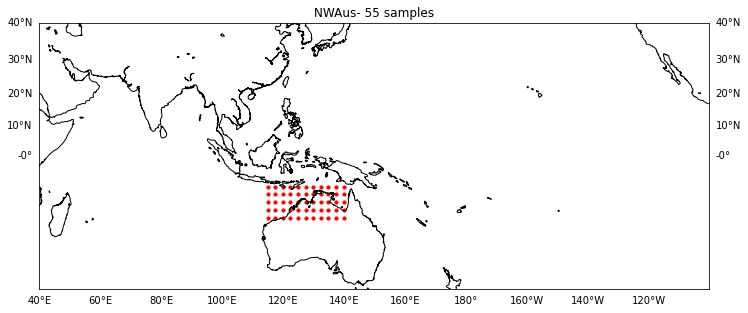

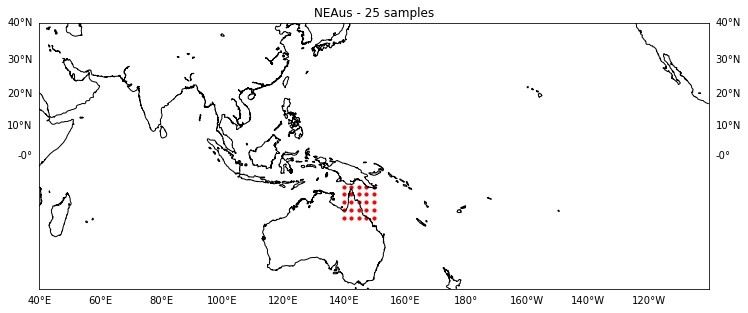

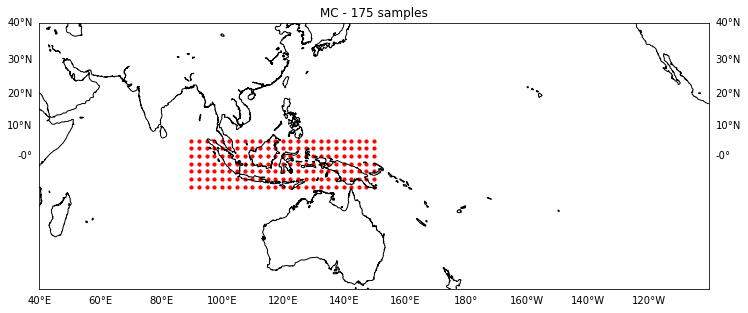

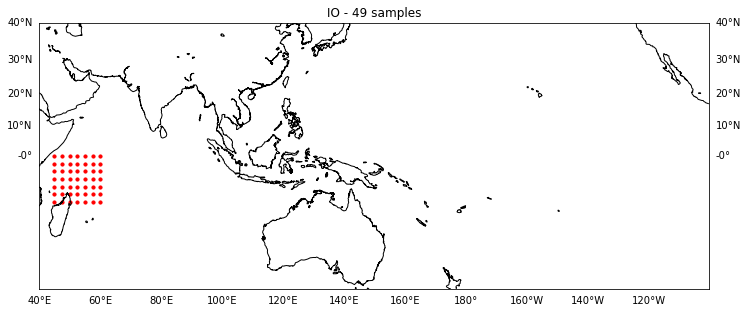

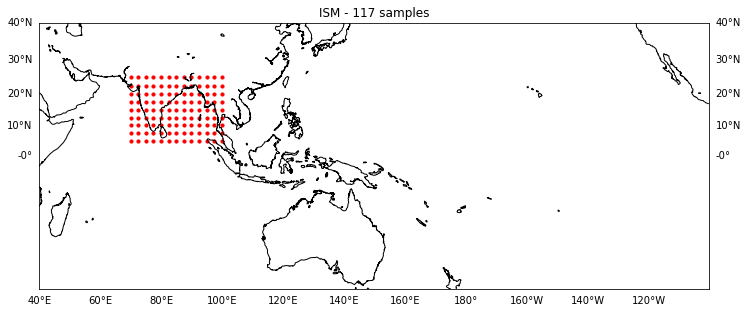

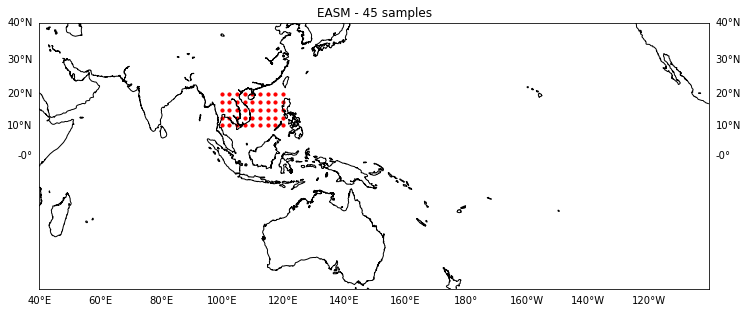

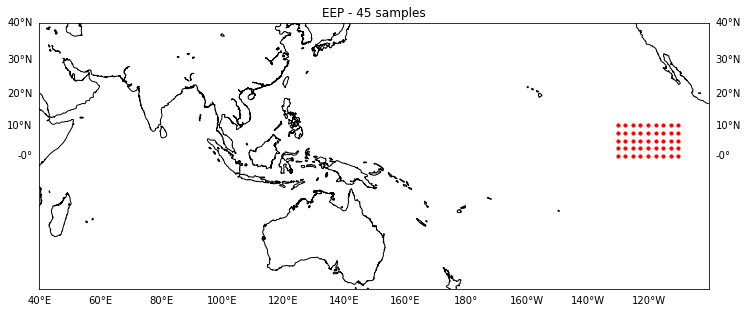

In [34]:
plt.figure(figsize=(12,15));
plt.title(f'NWAus- {len(nw_aus_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(nw_lon,nw_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'NEAus - {len(ne_aus_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ne_lon,ne_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'MC - {len(mc_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(mc_lon,mc_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'IO - {len(io_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(io_lon,io_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'ISM - {len(ism_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ism_lon,ism_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EASM - {len(easm_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(easm_lon,easm_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EEP - {len(eep_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(eep_lon,eep_lat,latlon=True,s=10,c='red')

# Extract Omega Measurements

In [35]:
omega = ds.variables['omega']

## Land & Ocean 

In [36]:
def regional_world_coord_index(regional_coords_output):
    regional_coords_index = []
    for i in range(len(regional_coords_output)):
        coords = regional_coords_output[i]
        indices = world_total_dict[coords]
        regional_coords_index.append(indices)
    return regional_coords_index

In [37]:
def regional_both_omega(regional_coords):
    regional_indices = regional_world_coord_index(regional_coords)
    
    unmask_omega_filter = []
    for (i,j) in tqdm(regional_indices):
        #print(i,j)
        # Take mid-tropospheric vertical velocity (500mb)
        omega_element = omega[:,5,i,j] 
        unmask_omega_filter.append(ma.MaskedArray.tolist(omega_element))
        
    time_series_omega = []
    for i in tqdm(range(len(unmask_omega_filter))):
        dict1 = dict(zip(final_times_all,unmask_omega_filter[i]))
        dict_com = dict1.copy()
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_omega.append(list(dict_fin.values()))
        
    regional_lat_lon_omega = list(zip([i[0] for i in regional_coords],
                                    [i[1] for i in regional_coords],
                                    time_series_omega))

    return regional_lat_lon_omega

In [38]:
nw_omega_both= regional_both_omega(nw_aus_coords)
ne_omega_both= regional_both_omega(ne_aus_coords)
mc_omega_both= regional_both_omega(mc_coords)
io_omega_both= regional_both_omega(io_coords)
eep_omega_both= regional_both_omega(eep_coords)
ism_omega_both= regional_both_omega(ism_coords)
easm_omega_both= regional_both_omega(easm_coords)

  0%|                                                                                           | 0/55 [00:00<?, ?it/s]C:\Users\Owner\AppData\Local\Temp\ipykernel_2596\1875643337.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega_element = omega[:,5,i,j]
100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1804.95it/s]


In [39]:
nw_average_omega_both= np.mean([i[2] for i in nw_omega_both],axis=0)
ne_average_omega_both= np.mean([i[2] for i in ne_omega_both],axis=0)
mc_average_omega_both= np.mean([i[2] for i in mc_omega_both],axis=0)
io_average_omega_both= np.mean([i[2] for i in io_omega_both],axis=0)
eep_average_omega_both= np.mean([i[2] for i in eep_omega_both],axis=0)
ism_average_omega_both= np.mean([i[2] for i in ism_omega_both],axis=0)
easm_average_omega_both= np.mean([i[2] for i in easm_omega_both],axis=0)

In [40]:
all_compiled = pd.DataFrame(list(zip(final_times_all,
                                     nw_average_omega_both,
                                     ne_average_omega_both,
                                     mc_average_omega_both,
                                     io_average_omega_both,
                                     eep_average_omega_both,
                                     ism_average_omega_both,
                                     easm_average_omega_both)),
                            columns=['Date','NW_Aus_Prec_Mean','NE_Aus_Prec_Mean','MC_Prec_Mean','IO_Prec_Mean','EEP_Prec_Mean','ISM_Prec_Mean','EASM_Prec_Mean'])

In [41]:
all_compiled[-50:]

,Date,NW_Aus_Prec_Mean,NE_Aus_Prec_Mean,MC_Prec_Mean,IO_Prec_Mean,EEP_Prec_Mean,ISM_Prec_Mean,EASM_Prec_Mean
745,01-02-2010,-0.031457,-0.012122,-0.006436,0.022365,-0.004113,-0.003267,0.015620
746,01-03-2010,-0.024220,-0.002522,-0.000745,0.012529,-0.011558,-0.006523,-0.007046
747,01-04-2010,-0.028693,-0.016322,-0.013728,0.022304,0.002153,0.009537,-0.006380
748,01-05-2010,-0.037820,-0.033842,-0.000682,0.025733,-0.004424,-0.002823,0.004309
749,01-06-2010,-0.031729,-0.016522,-0.002836,0.019610,-0.000402,-0.002361,-0.002313
750,01-07-2010,-0.031875,-0.018722,-0.011351,0.012794,-0.004646,0.000810,-0.005269
751,01-08-2010,-0.012493,0.003238,-0.003116,0.017937,0.000420,0.019340,-0.029447
752,01-09-2010,-0.029893,0.009358,0.002884,0.010284,-0.004447,0.012468,0.022176
753,01-10-2010,-0.036748,-0.017762,-0.011071,-0.004247,-0.011135,-0.002216,-0.010069
754,01-11-2010,-0.041984,-0.005722,-0.017036,0.020467,0.001976,0.014015,-0.002758


# Save Data

In [46]:
#all_compiled.to_csv('regional_mean_omega_all.csv')

In [42]:
all_compiled.to_csv('regional_mean_omega_all_extended.csv')